In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np 
import scanpy as sc 
import seaborn as sns
import matplotlib.pyplot as plt

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
import sys 
sys.path.append('/ix3/djishnu/alw399/SpaceOracle/src')

### Perturb

In [4]:
sample = 'lymph1a'
adata = sc.read_h5ad(f'/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_{sample}_visiumHD.h5ad')
adata


AnnData object with n_obs × n_vars = 22324 × 2116
    obs: 'sample', 'cell_type', 'secondary_annot', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_features', 'spatial_maps', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [5]:
from spaceoracle.tools.network import RegulatoryFactory

co_grn = RegulatoryFactory(
    colinks_path='/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD_colinks.pkl',
    annot='cell_type_int'
)

co_grn.links.keys()

2025-06-30 10:28:19.698885: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

dict_keys(['B', 'CD8+ T', 'DC', 'NK', 'Resting T', 'Tfh', 'Th2', 'Treg', 'gd T'])

In [6]:
from spaceoracle.gene_factory import GeneFactory

gf = GeneFactory.from_json(
    adata, 
    f'/ix/djishnu/shared/djishnu_kor11/lasso_runs/mouse_{sample}_visiumHD/run_params.json', 
    beta_scale_factor=1,
    beta_cap=None,
    co_grn=co_grn
)

In [ ]:
gf.load_betas(float16=True, obs_names=None)

In [5]:
prdm1 = adata[:, ['Prdm1']].to_df(layer='raw_count')
prdm1 = prdm1[prdm1['Prdm1'] >= 0].index

th2 = adata[((adata.obs['cell_type'] == 'Th2')), :].obs.index
tfh = adata[((adata.obs['cell_type'] == 'Tfh')), :].obs.index
treg = adata[((adata.obs['cell_type'] == 'Treg')), :].obs.index

transferred = (set(tfh) | set(th2) | set(treg)) & (set(prdm1))

len(transferred)

749

In [18]:
goi = 'Batf3-Ccr4'

simulated_gex = gf.perturb(
    target=['Batf3', 'Ccr4'],
    n_propagation=4,
    gene_expr=[0, 0],
    cells=np.where(gf.adata.obs.index.isin(transferred))[0],
)

simulated_gex.to_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_{sample}_visiumHD/{goi}_4n_0x_Cd4.parquet')

# simulated_gex = pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_{sample}_visiumHD/{goi}_4n_0x_Cd4.parquet')
# simulated_gex.shape

### Assemble parts

In [4]:
# full adata 
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
adata

AnnData object with n_obs × n_vars = 89296 × 2116
    obs: 'sample', 'cell_type', 'secondary_annot', 'cell_type_int', 'x_umap', 'y_umap', 'banksy_cluster'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_features', 'spatial_maps', 'spatial_unscaled'
    layers: 'corrected_count', 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [5]:
prdm1 = adata[:, ['Prdm1']].to_df(layer='raw_count')
prdm1 = prdm1[prdm1['Prdm1'] > 0].index

ct_transfer = '1der'

th2 = adata[((adata.obs['cell_type'] == 'Th2')), :].obs.index
tfh = adata[((adata.obs['cell_type'] == 'Tfh')), :].obs.index
treg = adata[((adata.obs['cell_type'] == 'Treg')), :].obs.index

transferred = (set(tfh) | set(th2) | set(treg)) & set(prdm1)
transferred = list(transferred)

len(transferred)

107

In [14]:
# gex_df = ko_adata[:, ['Prdm1', 'Ccr4']].to_df(layer='raw_count')
gex_df = adata[:, ['Ccr4']].to_df(layer='raw_count')
ccr4neg = gex_df[(gex_df['Ccr4'] < 1)].index

ccr4neg_th2 = adata[
        (adata.obs.index.isin(ccr4neg)) 
        # & ((ko_adata.obs.cell_type == 'Th2') | (ko_adata.obs.cell_type == 'Tfh') | (ko_adata.obs.cell_type == 'Treg'))
        & ((adata.obs.cell_type == 'Th2') | (adata.obs.cell_type == 'Tfh'))
        # & (ko_adata.obs.cell_type == 'Th2')
        # & (ko_adata.obs.cell_type == 'Tfh')
    ].obs_names

ccr4pos_th2 = adata[
        (~adata.obs.index.isin(ccr4neg)) 
        & (adata.obs.cell_type == 'Th2')
        # & ((ko_adata.obs.cell_type == 'Th2') | (ko_adata.obs.cell_type == 'Tfh'))
    ].obs_names
len(ccr4pos_th2)

34

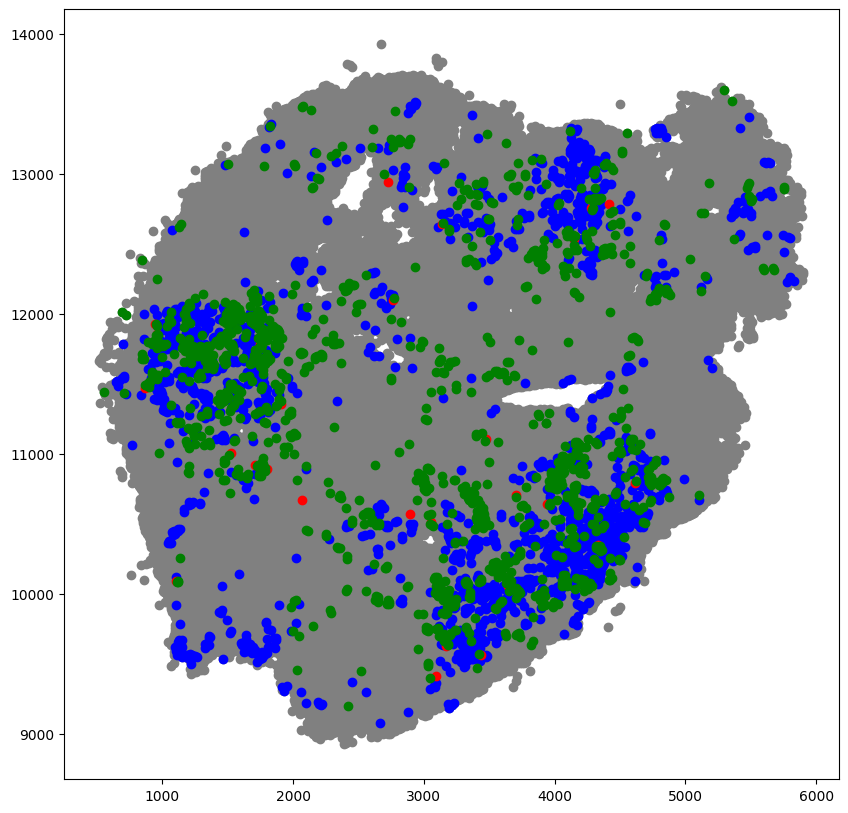

In [16]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(
    adata.obsm['spatial'][:, 0], 
    adata.obsm['spatial'][:, 1],
    color='gray'
)
plt.scatter(
    adata[adata.obs.cell_type == 'DC'].obsm['spatial'][:, 0],
    adata[adata.obs.cell_type == 'DC'].obsm['spatial'][:, 1],
    color='blue')
plt.scatter(
    adata[ccr4pos_th2].obsm['spatial'][:, 0],
    adata[ccr4pos_th2].obsm['spatial'][:, 1],
    color='red'
)
plt.scatter(
    adata[ccr4neg_th2].obsm['spatial'][:, 0],
    adata[ccr4neg_th2].obsm['spatial'][:, 1],
    color='green'
)

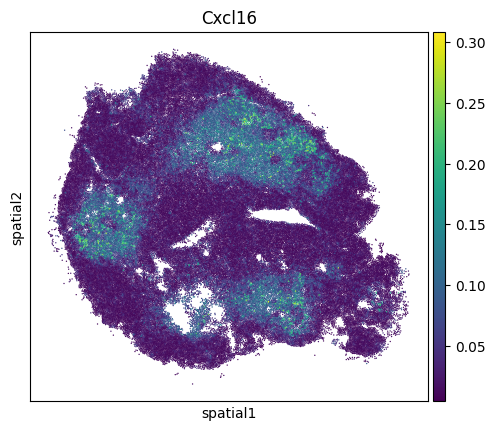

In [8]:
sc.pl.spatial(adata, color=['Cxcl16'], spot_size=20, 
              layer='imputed_count', cmap='viridis')

### Visualize

In [6]:
banksy_df = pd.read_csv('/ix/djishnu/shared/djishnu_kor11/banksy_outputs/mouse_lymph1_visiumHD_banksy_celltypes.csv', index_col=0)
banksy_df.index = banksy_df.index.astype(str)

adata.obs = pd.concat([adata.obs, banksy_df], axis=1)
adata.obs.head(3)

sample cell_type secondary_annot cell_type_int    x_umap  \
object_id                                                                
247819     unmatched         B             NaN             0 -1.589480   
200373     unmatched    CD8+ T             Tfh             1  7.992571   
190000     unmatched         B             NaN             0  1.204481   

             y_umap  banksy_cluster    x_umap    y_umap  banksy_cluster  
object_id                                                                
247819    -0.168589               0 -1.589480 -0.168589               0  
200373    -1.810663               3  7.992571 -1.810663               3  
190000     0.755010               7  1.204481  0.755010               7

In [7]:
colors = [
    "#cd5330",
    "#4cb6af",
    "#b05cc6",
    "#74b854",
    "#6f7bca",
    "#c49443",
    "#c55d93",
    "#657e3b",
    "#c85d60"
]

cmap = {c: colors[i] for i, c in enumerate(adata.obs['cell_type'].unique())}

/tmp/ipykernel_8780/1557705117.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


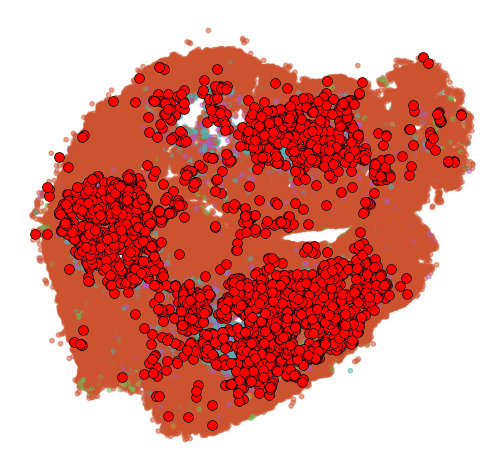

In [8]:
data = pd.concat([adata.obs, pd.DataFrame(adata.obsm['spatial'], index=adata.obs.index, columns=['x', 'y'])], axis=1)

plt.scatter(
    x = data['x'],
    y = data['y'],
    c = data['cell_type'].map(cmap),
    cmap='tab20',
    s = 10,
    alpha = 0.5,
)

transferred = list(transferred)

plt.scatter(
    x = data.loc[list(transferred), :]['x'],
    y = data.loc[list(transferred), :]['y'],
    c = 'red', edgecolors='black', linewidths=0.5,
    s = 50,
)

plt.gca().set_aspect('equal')
plt.gca().axis('off')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

### Batch correct

In [318]:
ko_adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')
ko_adata

AnnData object with n_obs × n_vars = 92969 × 2116
    obs: 'cell_type', 'secondary_annot', 'cell_type_int'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_features', 'spatial_maps', 'spatial_unscaled'
    layers: 'corrected_count', 'imputed_count', 'normalized_count', 'raw_count'

In [319]:
ko_transferred = ko_adata[:, ['Prdm1', 'Ccr4']].to_df(layer='raw_count')
ko_transferred = ko_transferred[((ko_transferred['Prdm1'] > 0) & (ko_transferred['Ccr4'] < 1))].index

ko_transferred = ko_adata[
        (ko_adata.obs.index.isin(ko_transferred)) 
        & ((ko_adata.obs.cell_type == 'Th2') | (ko_adata.obs.cell_type == 'Tfh') | (ko_adata.obs.cell_type == 'Treg'))
        # & (ko_adata.obs.cell_type == 'Th2')
        # & (ko_adata.obs.cell_type == 'Tfh')
    ].obs_names

ko_transferred = list(ko_transferred)
len(ko_transferred)

60

In [ ]:
data = pd.concat([ko_adata.obs, pd.DataFrame(ko_adata.obsm['spatial'], index=ko_adata.obs.index, columns=['x', 'y'])], axis=1)

plt.scatter(
    x = data['x'],
    y = data['y'],
    c = data['cell_type'].map(cmap),
    cmap='tab20',
    s = 10,
    alpha = 0.5,
)

plt.scatter(
    x = data.loc[list(ko_transferred), :]['x'],
    y = data.loc[list(ko_transferred), :]['y'],
    c = 'red', edgecolors='black', linewidths=0.5,
    s = 50,
)

plt.gca().set_aspect('equal')
plt.gca().axis('off')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [11]:
# # combat didn't seem to work well (UMAP still looked separated)
# sc.pp.combat(combined_adata, key='sample')

In [12]:
import scvi

batch_key = 'batch'

# Step 1: Prepare and train on reference
adata_ref = adata.copy()
adata_ref.obs[batch_key] = 'ref_batch'
adata_ref.obs[batch_key] = adata_ref.obs[batch_key].astype('category')

scvi.model.SCVI.setup_anndata(adata_ref, batch_key="batch", layer="raw_count")

scvi_ref = scvi.model.SCVI(
    adata_ref,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)
scvi_ref.train()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ihome/djishnu/alw399/.local/lib/python3.9/site-pack ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ihome/djishnu/alw399/.local/lib/python3.9/site-pack ...
You are using a CUDA device ('NVIDIA L40S') tha

Epoch 90/90: 100%|██████████| 90/90 [05:25<00:00,  2.99s/it, v_num=1, train_loss_step=446, train_loss_epoch=428]

`Trainer.fit` stopped: `max_epochs=90` reached.


Epoch 90/90: 100%|██████████| 90/90 [05:25<00:00,  3.62s/it, v_num=1, train_loss_step=446, train_loss_epoch=428]


In [13]:
adata_query = ko_adata.copy()
adata_query.obs[batch_key] = 'query_batch'
adata_query.obs[batch_key] = adata_query.obs[batch_key].astype('category')

scvi.model.SCVI.prepare_query_anndata(adata_query, scvi_ref)

INFO     Found 100.0% reference vars in query data.                                                                


In [14]:
scvi_query = scvi.model.SCVI.load_query_data(
    adata_query,
    scvi_ref,
)

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ihome/djishnu/alw399/.local/lib/python3.9/site-pack ...


In [15]:
scvi_query.train(max_epochs=200, plan_kwargs={"weight_decay": 0.0})

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ihome/djishnu/alw399/.local/lib/python3.9/site-pack ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ihome/djishnu/alw399/.local/lib/python3.9/site-pack ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [09:09<00:00,  2.74s/it, v_num=1, train_loss_step=393, train_loss_epoch=411]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [09:09<00:00,  2.75s/it, v_num=1, train_loss_step=393, train_loss_epoch=411]


In [16]:
corrected_expr_ref = scvi_ref.get_normalized_expression(
    adata_ref,
    return_mean=True,
    library_size=1e4)

In [17]:
corrected_expr_query = scvi_query.get_normalized_expression(
    adata_query, 
    return_mean=True,
    library_size=1e4)

In [18]:
adata.layers['corrected_count'] = adata.X.copy()
ko_adata.layers['corrected_count'] = ko_adata.X.copy()

In [19]:
# adata.write_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
# ko_adata.write_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')

In [ ]:
adata.obs['sample'] = 'lymph1'
ko_adata.obs['sample'] = 'lymphKO4'
combined_adata = sc.concat([adata, ko_adata], axis=0)
# sc.tl.pca(adata, n_comps=50)

In [21]:
combined_adata.X = combined_adata.layers['corrected_count']

In [22]:
# sc.tl.pca(combined_adata, n_comps=50)

In [27]:
# sc.pp.neighbors(combined_adata, use_rep='X_pca', n_neighbors=15)
# sc.tl.umap(combined_adata)

# sc.pl.umap(combined_adata, color=['cell_type', 'sample'], ncols=2)

In [ ]:
# import scanpy.external as sce
# sce.pp.harmony_integrate(combined_adata, "sample", basis='X_umap', adjusted_basis='X_umap_harmony')
# sc.pl.embedding(combined_adata, "X_umap_harmony", color=['cell_type', 'sample'], ncols=2)

### Correlation

In [320]:
N = 1500

adata.obs['sample'] = 'lymph1'
ko_adata.obs['sample'] = 'lymphKO4'

combined_adata = sc.concat([adata[transferred, :], ko_adata[ko_transferred, :]])
combined_adata.X = combined_adata.layers['corrected_count']
print(combined_adata.X.min(), combined_adata.X.max())
sc.pp.log1p(combined_adata)

sc.tl.rank_genes_groups(combined_adata, 'sample', method='wilcoxon', use_raw=False)
degs_df = sc.get.rank_genes_groups_df(combined_adata, group='lymphKO4', key='rank_genes_groups')
# degs_df = degs_df[degs_df['pvals_adj'] < 0.05]

# top_degs_df = degs_df.sort_values('logfoldchanges', key=abs, ascending=False).head(N)
top_degs_df = degs_df.sort_values('scores', key=abs, ascending=False).head(N)

0.0 142.0


In [321]:
goi = 'Ccr4'

simulated_gex = [
    pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1{part}_visiumHD/{goi}_4n_0x_{ct_transfer}.parquet')
    # pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1{part}_visiumHD/{goi}_4n_0x_Cd4.parquet')
    for part in ['a', 'b', 'c', 'd']]
simulated_gex = pd.concat(simulated_gex, axis=0)
simulated_gex.shape

(89296, 2116)

In [322]:
simulated_gex.head(3)

Adam11    Adam12    Adam23     Adam8  Adamts10     Adap1  \
Ccr4_4n_0x                                                               
276144      0.012990  0.015349  0.005604  0.009147  0.047899  0.036853   
260035      0.011151  0.010507  0.025731  0.009698  0.046029  0.048898   
177075      0.006210  0.010143  0.003802  0.006682  0.054852  0.034954   

               Adcy6    Adgre4    Adgre5    Adgrg6  ...   Zkscan6     Zmat3  \
Ccr4_4n_0x                                          ...                       
276144      0.003447  0.001989  0.069949  0.004295  ...  0.031840  0.008163   
260035      0.006142  0.052218  0.067920  0.004704  ...  0.034032  0.006600   
177075      0.001432  0.004995  0.081334  0.009265  ...  0.049056  0.017736   

               Zmat5     Zmym1   Zmynd11   Zmynd12   Zmynd15     Znfx1  \
Ccr4_4n_0x                                                               
276144      0.027365  0.016236  0.131213  0.000186  0.013177  0.028637   
260035      0.023167  0.021564  0.109341  0.000206  0.011718  0.022114   
177075      0.025390  0.017715  0.145985  0.000064  0.006145  0.028169   

              Znhit2      Zup1  
Ccr4_4n_0x                      
276144      0.024689  0.064330  
260035      0.022988  0.081156  
177075      0.023435  0.071011  

[3 rows x 2116 columns]

In [323]:
gex_control = adata[transferred, :].to_df(layer='corrected_count').copy()
gex_ko = ko_adata[ko_transferred, :].to_df(layer='corrected_count').copy()

In [324]:
delta_sim = simulated_gex.loc[transferred, :] - adata[transferred, :].to_df(layer='imputed_count')
gex_sim = gex_control + delta_sim 
gex_sim = simulated_gex.loc[transferred, :]

In [325]:
delta_gt = gex_control.mean(axis=0) - gex_ko.mean(axis=0)

In [326]:
changed_genes = top_degs_df.head(N)['names'].values

if 'Ccr4' in changed_genes:
    changed_genes = changed_genes[changed_genes != 'Ccr4']

In [327]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [328]:
# gex_control = gex_control[changed_genes].sum(axis=0)
# gex_sim = gex_sim[changed_genes].sum(axis=0)
# gex_ko = gex_ko[changed_genes].sum(axis=0)

gex_control = gex_control[changed_genes].mean(axis=0)
gex_sim = gex_sim[changed_genes].mean(axis=0)
gex_ko = gex_ko[changed_genes].mean(axis=0)

In [329]:
corr = pearsonr(gex_ko, gex_sim).statistic
corr_control = pearsonr(gex_ko, gex_control).statistic

corr, corr_control

(0.8940274797425787, 0.8025815379768261)

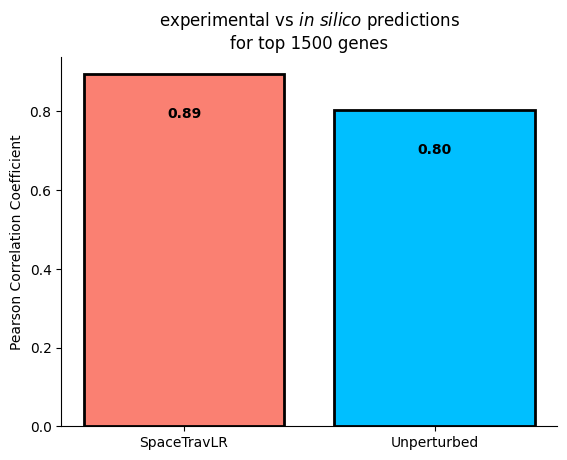

In [330]:
correlations = {'SpaceTravLR': corr, 'Unperturbed': corr_control}

plt.bar(correlations.keys(), correlations.values(), linewidth=2, 
    edgecolor='black', color=['salmon', 'deepskyblue', 'grey'])

plt.ylabel('Pearson Correlation Coefficient')
plt.title(r'experimental vs $\it{in\ silico}$ predictions' + f'\nfor top ' + str(N) + ' genes')

for i, (key, value) in enumerate(correlations.items()):
    plt.text(i, max(value, 0) - 0.1, f'{value:.2f}', ha='center', 
        va='center', color='black', fontweight='bold')
    
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(f'pearson_{ct_transfer}_{N}.svg', transparent=True, bbox_inches='tight', dpi=300, format='svg')
plt.show()

In [30]:
corr = spearmanr(gex_ko, gex_sim).statistic
corr_control = spearmanr(gex_ko, gex_control).statistic

corr, corr_control

(0.7572345000370163, 0.6869749302348925)

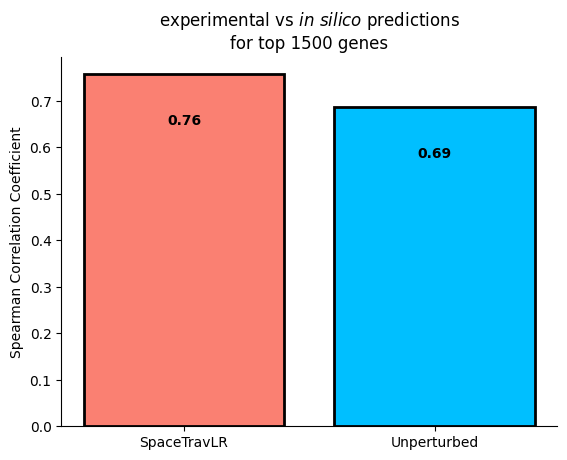

In [31]:
correlations = {'SpaceTravLR': corr, 'Unperturbed': corr_control}

plt.bar(correlations.keys(), correlations.values(), linewidth=2, 
    edgecolor='black', color=['salmon', 'deepskyblue', 'grey'])

plt.ylabel('Spearman Correlation Coefficient')
plt.title(r'experimental vs $\it{in\ silico}$ predictions' + f'\nfor top ' + str(N) + ' genes')

for i, (key, value) in enumerate(correlations.items()):
    plt.text(i, max(value, 0) - 0.1, f'{value:.2f}', ha='center', 
        va='center', color='black', fontweight='bold')
    
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(f'spearman_{ct_transfer}_{N}.svg', transparent=True, bbox_inches='tight', dpi=300, format='svg')
plt.show()

In [32]:
from numba import jit

np.random.seed(42)

# Cannibalized from CellOracle
@jit(nopython=True)
def permute_rows_nsign(A: np.ndarray) -> None:
    """Permute in place the entries and randomly switch the sign for each row of a matrix independently.
    """
    plmi = np.array([+1, -1])
    for i in range(A.shape[0]):
        np.random.shuffle(A[i, :])
        A[i, :] = A[i, :] * np.random.choice(plmi, size=A.shape[1])

delta_sim = simulated_gex.loc[transferred, :] - adata[transferred, :].to_df(layer='imputed_count')
delta_rand = delta_sim.values.copy()
permute_rows_nsign(delta_rand)

delta_rand = pd.DataFrame(delta_rand, index=delta_sim.index, columns=delta_sim.columns)

In [33]:
delta_rand = delta_rand.mean(axis=0)
delta_sim = delta_sim.mean(axis=0)
delta_gt = gex_control.mean(axis=0) - gex_ko.mean(axis=0)

# delta_rand = delta_rand.sum(axis=0)
# delta_sim = delta_sim.sum(axis=0)
# delta_gt = gex_control.sum(axis=0) - gex_ko.sum(axis=0)


In [ ]:
corr = spearmanr(delta_sim[changed_genes], delta_gt[changed_genes]).statistic
corr_control = spearmanr(delta_rand[changed_genes], delta_gt[changed_genes]).statistic

corr, corr_control

In [36]:
corr = pearsonr(delta_sim[changed_genes], delta_gt[changed_genes]).statistic
corr_control = pearsonr(delta_rand[changed_genes], delta_gt[changed_genes]).statistic

corr, corr_control

(0.11930030275954961, -0.0028538767526059485)

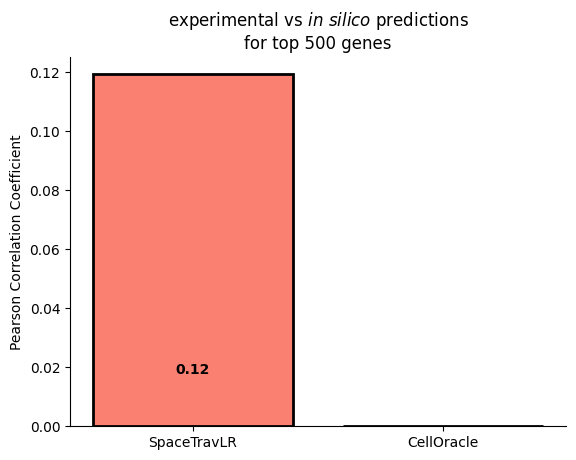

In [37]:
correlations = {'SpaceTravLR': corr, 'CellOracle': 0}

plt.bar(correlations.keys(), correlations.values(), linewidth=2, 
    edgecolor='black', color=['salmon', 'deepskyblue', 'grey'])

plt.ylabel('Pearson Correlation Coefficient')
plt.title(r'experimental vs $\it{in\ silico}$ predictions' + f'\nfor top ' + str(N) + ' genes')

for i, (key, value) in enumerate(correlations.items()):
    if value > 0:
        plt.text(i, max(value, 0) - 0.1, f'{value:.2f}', ha='center', 
            va='center', color='black', fontweight='bold')
    
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(f'pearson_{ct_transfer}_{N}_delta.svg', transparent=True, bbox_inches='tight', dpi=300, format='svg')
plt.show()

In [62]:
delta_sim.sort_values(key=abs, ascending=False).head(20).index

Index(['Ccr4', 'H2-Aa', 'H2-Ab1', 'Sh2d2a', 'Ctla4', 'Cd3g', 'Cd74', 'Slamf6',
       'Cd3d', 'Ms4a4b', 'H2-Eb1', 'Icos', 'H2-Ob', 'Ccl22', 'Thy1', 'Izumo1r',
       'Lck', 'Cd79b', 'Srpk3', 'Ptprc'],
      dtype='object')

In [52]:
# save file to find modulator that counteracts Ccr4 KO
delta_sim.to_csv('delta_pred.csv')

### Gene vs proximity plots

In [42]:
from spaceoracle.models.parallel_estimators import create_spatial_features
from spaceoracle.plotting.cartography import xy_from_adata
from tqdm import tqdm

radius = 200

spf = pd.read_csv(f'spf_control_{radius}.csv', index_col=0)
spf.index = spf.index.astype(str)

# # check that computational subsampling reflects the spatial distribution of cell types
# spf = []
# for part in tqdm(['a', 'b', 'c', 'd']):
#     adata = sc.read_h5ad(f'/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1{part}_visiumHD.h5ad')
#     spf.append(create_spatial_features(
#         x=adata.obsm['spatial'][:, 0], 
#         y=adata.obsm['spatial'][:, 1], 
#         celltypes=adata.obs.cell_type, 
#         obs_index=adata.obs_names,
#         radius=radius
#     ))

# spf = pd.concat(spf)
# spf

In [43]:
xy = xy_from_adata(adata)

In [44]:
cell_groups = {
    'B' : ['B'],
    'CD8+ T' : ['CD8+ T']
}

In [45]:
from scipy.stats import pearsonr
from spaceoracle.plotting.cartography import xy_from_adata
import os 

def plot_gene_vs_proximity(perturb_target, gene, color_gene, cell_filter, proximity_cell,
                          proximity_threshold=150, ax=None, mode='ko',
                         perturbed_df=None, spf=None):
    
    spf = spf.copy()
    spf = spf.loc[perturbed_df.index, :]
    
    datadf = spf[
        [i+'_within' for i in cell_groups[proximity_cell]
            ]].sum(1).to_frame().join(adata.obs.cell_type).query(
             f'cell_type.isin(["{cell_filter}"])').join(xy).join(
        ((perturbed_df-adata.to_df(layer='imputed_count'))/adata.to_df(layer='imputed_count'))*100
    )
    datadf = datadf[datadf[0] < proximity_threshold]
    
    if ax is None:
        ax = plt.gca()
    
    try:
        corr = pearsonr(datadf[0], datadf[gene]).statistic
        ax.set_title(f"{perturb_target} {mode.upper()} in\n{cell_filter}\nCorrelation: {corr:.4f}")
    except:
        corr = 0
        ax.set_title(f"{perturb_target} {mode.upper()} in\n{cell_filter}")
        
    scatter = ax.scatter(
        datadf[0], 
        datadf[gene], 
        c=datadf[color_gene],
        cmap='rainbow',
    )
    plt.colorbar(scatter, label=f'{color_gene} % change', shrink=0.75, ax=ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(f'{gene} % change')
    ax.set_xlabel(f'Number of {proximity_cell} within 200um')
    # ax.set_xlabel('Number of T cells within 200um')
    
    return ax, datadf

In [ ]:
ax, datadf = plot_gene_vs_proximity(
    perturb_target='Ccr4', 
    # proximity_cell='B',  
    proximity_cell='CD8+ T',
    gene='Itgb7',
    color_gene='Il2rb', 
    cell_filter='Th2', 
    spf = spf,
    proximity_threshold=200,
    perturbed_df=simulated_gex.loc[transferred, :]
    
)
# plt.savefig('mouse_lymphnode_visiumHD_Ccr4_4n_0x_1der_Ccr22_vs_Ccl5_proxCD8.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
ax, datadf = plot_gene_vs_proximity(
    perturb_target='Ccr4', 
    proximity_cell='B',
    gene='Itgb7',
    color_gene='Il2rb', 
    cell_filter='Th2', 
    spf = spf,
    proximity_threshold=500,
    perturbed_df=simulated_gex.loc[transferred, :]
    
)
# plt.savefig('mouse_lymphnode_visiumHD_Ccr4_4n_0x_1der_Ccr22_vs_Ccl5_proxCD8.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
ax, datadf = plot_gene_vs_proximity(
    perturb_target='Ccr4', 
    proximity_cell='CD8+ T',
    gene='Igfbp7',
    color_gene='Cap1', 
    cell_filter='Th2', 
    spf = spf,
    proximity_threshold=200,
    perturbed_df=simulated_gex.loc[transferred, :]
    
)
plt.show()

In [ ]:
ax, datadf = plot_gene_vs_proximity(
    perturb_target='Ccr4', 
    proximity_cell='B',  
    gene='Igfbp7',
    color_gene='Cap1', 
    cell_filter='Th2', 
    spf = spf,
    proximity_threshold=500,
    perturbed_df=simulated_gex.loc[transferred, :]
    
)
plt.show()

### Quiver plots

In [12]:
from spaceoracle.plotting.cartography import Cartography

cmap['transferred'] = 'red'
chart = Cartography(adata[adata.obs.cell_type.isin(['Th2']), :], color_dict=cmap)
chart.adata.obs['cell_type'] = ['transferred' if x in transferred else chart.adata.obs.loc[x, 'cell_type'] for x in chart.adata.obs.index]
chart.adata.obs['cell_type'].value_counts()

2025-06-24 10:40:42.461891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

cell_type
Th2            403
transferred     30
Name: count, dtype: int64

In [ ]:
chart.adata.obsm['X_umap'] = chart.adata.obsm['spatial']

_ = chart.plot_umap_quiver(
    perturb_target='Ccr4',
    grid_scale=5,
    vector_scale=50,
    n_neighbors=50,
    figsize=(5, 5), 
    hue='cell_type',
    alpha=0.65,
    perturbed_df=simulated_gex,
    scatter_size=25,
    remove_null=True,
    legend_on_loc=True,
    legend_fontsize=6,
)

### Flipping dots

In [6]:
adata

AnnData object with n_obs × n_vars = 89296 × 2116
    obs: 'sample', 'cell_type', 'secondary_annot', 'cell_type_int', 'x_umap', 'y_umap', 'banksy_cluster'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_features', 'spatial_maps', 'spatial_unscaled'
    layers: 'corrected_count', 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [7]:
b_counts = adata.obs['banksy_cluster'].value_counts()
adata.obs['banksy_cluster'] = [x if b_counts[x] > 100 else 'other' for x in adata.obs['banksy_cluster']]
adata.obs['banksy_cluster'] = adata.obs['banksy_cluster'].astype('category')

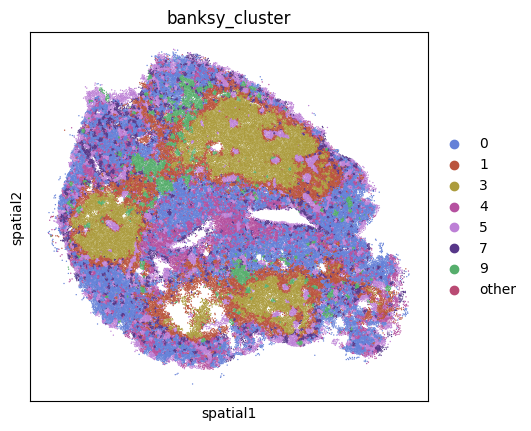

In [8]:
colors = [
    "#6581d8",
    "#ac9c3d",
    "#573789",
    "#56ae6c",
    "#b551a0",
    "#ba543d",
    "#bd80d6",
    "#b94a73"
]

color_dict = {x: colors[i] for i, x in enumerate(adata.obs['banksy_cluster'].unique())}
sc.pl.spatial(adata, color='banksy_cluster', palette=color_dict, spot_size=20)

In [9]:
adata_ = adata[adata.obs.cell_type == 'Th2']

# Check to see if Ccr4 KO changes cell type identity
# adata_ = adata[adata.obs.index.isin(transferred)]
# adata_.obs['banksy_cluster'] = adata.obs['cell_type']

adata_

View of AnnData object with n_obs × n_vars = 433 × 2116
    obs: 'sample', 'cell_type', 'secondary_annot', 'cell_type_int', 'x_umap', 'y_umap', 'banksy_cluster'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'received_ligands', 'received_ligands_tfl', 'umap', 'banksy_cluster_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_features', 'spatial_maps', 'spatial_unscaled'
    layers: 'corrected_count', 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [10]:
from spaceoracle.plotting.cartography import Cartography

chart = Cartography(adata_, color_dict)

2025-07-01 22:43:26.664900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [11]:
# goi = 'Ccr4'
goi = 'Ddit3-Ccr4'
# goi = 'Egr1-Ccr4'
# goi = 'Syk-Ccr4'
# goi = 'Batf3-Ccr4'
# goi = 'Irf1-Ccr4'

simulated_gex = [
    # pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1{part}_visiumHD/{goi}_4n_0x_Th2.parquet')
    pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1{part}_visiumHD/{goi}_4n_0x_Th2.parquet')
    for part in ['a', 'b', 'c', 'd']]

simulated_gex = pd.concat(simulated_gex, axis=0)
simulated_gex.shape

# SpaceTravLR
simulated_df = simulated_gex.loc[chart.adata.obs.index]
simulated_df

Adam11    Adam12    Adam23     Adam8  Adamts10     Adap1  \
object_id                                                               
205621     0.033682  0.015682  0.029757  0.041193  0.082051  0.134311   
198055     0.026961  0.021694  0.020283  0.048693  0.072981  0.153612   
172832     0.028045  0.013899  0.015317  0.039197  0.057006  0.142313   
219678     0.029573  0.020801  0.015212  0.053130  0.068970  0.188177   
259850     0.034733  0.016717  0.013821  0.048098  0.066021  0.144789   
...             ...       ...       ...       ...       ...       ...   
247282     0.029380  0.026949  0.014757  0.055184  0.072135  0.164600   
211705     0.028997  0.025972  0.013775  0.050454  0.061870  0.142553   
197779     0.026677  0.029701  0.013621  0.046670  0.081778  0.169157   
198374     0.030507  0.022639  0.014736  0.054795  0.070536  0.141228   
199529     0.028376  0.015222  0.021200  0.045826  0.059116  0.141648   

              Adcy6    Adgre4    Adgre5    Adgrg6  ...   Zkscan6     Zmat3  \
object_id                                          ...                       
205621     0.010419  0.001958  0.085663  0.005500  ...  0.042307  0.003097   
198055     0.016732  0.001349  0.098725  0.005645  ...  0.038833  0.002859   
172832     0.013736  0.001108  0.093021  0.003542  ...  0.046548  0.024518   
219678     0.013654  0.001271  0.095100  0.007335  ...  0.043265  0.003107   
259850     0.011881  0.002629  0.088401  0.007020  ...  0.038880  0.003287   
...             ...       ...       ...       ...  ...       ...       ...   
247282     0.020399  0.001214  0.105580  0.008541  ...  0.032537  0.001819   
211705     0.011451  0.002039  0.084198  0.007371  ...  0.042249  0.001886   
197779     0.024149  0.001038  0.105730  0.006581  ...  0.035726  0.001862   
198374     0.020356  0.001386  0.135355  0.007470  ...  0.037152  0.002568   
199529     0.010544  0.001995  0.112650  0.004652  ...  0.036584  0.003009   

              Zmat5     Zmym1   Zmynd11  Zmynd12   Zmynd15     Znfx1  \
object_id                                                              
205621     0.034391  0.008057  0.140079      0.0  0.027054  0.016620   
198055     0.036635  0.015029  0.148809      0.0  0.028245  0.022923   
172832     0.040228  0.013755  0.150766      0.0  0.019443  0.015483   
219678     0.039705  0.010922  0.149622      0.0  0.023774  0.021136   
259850     0.034604  0.009055  0.129367      0.0  0.021865  0.019314   
...             ...       ...       ...      ...       ...       ...   
247282     0.038699  0.021781  0.130764      0.0  0.025243  0.025085   
211705     0.031184  0.008633  0.169024      0.0  0.027635  0.026561   
197779     0.044799  0.012931  0.143846      0.0  0.026669  0.039211   
198374     0.037044  0.011528  0.148143      0.0  0.025564  0.024873   
199529     0.034914  0.008539  0.157853      0.0  0.024941  0.024442   

             Znhit2      Zup1  
object_id                      
205621     0.019204  0.038001  
198055     0.022275  0.035578  
172832     0.019374  0.034110  
219678     0.021940  0.038381  
259850     0.022795  0.035802  
...             ...       ...  
247282     0.022063  0.058249  
211705     0.022492  0.039108  
197779     0.021893  0.037606  
198374     0.027595  0.040494  
199529     0.020973  0.037768  

[433 rows x 2116 columns]

In [13]:
simulated_df['Ccr4'].sum(), simulated_df['Ddit3'].sum()

(0.0, 0.0)

In [14]:
delta_X = (simulated_df - chart.unperturbed_expression).values
gene_mtx = chart.unperturbed_expression.values
gene_mtx.shape, delta_X.shape

((433, 2116), (433, 2116))

In [15]:
P = chart.compute_transition_probabilities(
    delta_X, 
    embedding=chart.adata.obsm['X_umap'])
P.shape

(433, 433)

In [16]:
chart.adata.obs['banksy_cluster'].unique()

[1, 3, 9, 4, 5, 7]
Categories (6, object): [1, 3, 4, 5, 7, 9]

In [17]:
try:
    chart.adata.obs.drop(['transition'], axis=1, inplace=True)
except:
    pass

In [27]:
chart.get_transition_annot(
    P,
    allowed_fates=chart.adata.obs['banksy_cluster'].unique(), 
    thresh=0, 
    annot='banksy_cluster'
)

100%|██████████| 134/134 [00:01<00:00, 83.12it/s]


source ct 1 Counter({7: 38, 1: 37, 4: 25, 9: 24, 5: 6, 3: 4}) 0.0007498188685085858 0.0003953435139499321


100%|██████████| 202/202 [00:02<00:00, 84.54it/s]


source ct 3 Counter({3: 109, 1: 57, 7: 17, 9: 13, 4: 5, 5: 1}) 0.0009629625368272506 0.00017459623038699646


100%|██████████| 35/35 [00:00<00:00, 83.93it/s]


source ct 9 Counter({9: 35}) 0.001753602509977572 0.0014191236442952515


100%|██████████| 22/22 [00:00<00:00, 83.42it/s]


source ct 4 Counter({7: 13, 9: 3, 4: 2, 1: 2, 5: 1, 3: 1}) 0.0012898434017625576 0.0


100%|██████████| 38/38 [00:00<00:00, 82.45it/s]


source ct 5 Counter({7: 28, 5: 7, 4: 2, 9: 1}) 0.002341706464923934 0.0


100%|██████████| 2/2 [00:00<00:00, 80.88it/s]

source ct 7 Counter({5: 2}) 0.00203768514886495 0.0


In [28]:
xy = pd.DataFrame(adata.obsm['spatial'], index=adata.obs.index, columns=['x', 'y'])

In [29]:
adata.obs['x'] = adata.obsm['spatial'][:, 0]
adata.obs['y'] = adata.obsm['spatial'][:, 1]

In [30]:
# ct_points_wt, ct_points_ko = chart.make_celltype_dict(annot='banksy_cluster')

In [31]:
# import alphashape
# from shapely.geometry import Point
from matplotlib.legend_handler import HandlerTuple
import matplotlib
import seaborn as sns 

In [32]:
# alpha_shape_wt = {}
# for ct, points in ct_points_wt.items():
#     alpha_shape_wt[ct] = alphashape.alphashape(points, alpha=0.05)

In [33]:
chart.adata.obs['banksy_cluster'] = chart.adata.obs['banksy_cluster'].cat.remove_unused_categories()
chart.adata.obs['transition'] = chart.adata.obs['transition'].astype('category')
chart.adata.obs['transition']=chart.adata.obs['transition'].cat.remove_unused_categories()

In [34]:
df = chart.adata.obs[['banksy_cluster', 'transition']].copy()
counts = df.groupby(['banksy_cluster', 'transition']).size().unstack(fill_value=0)

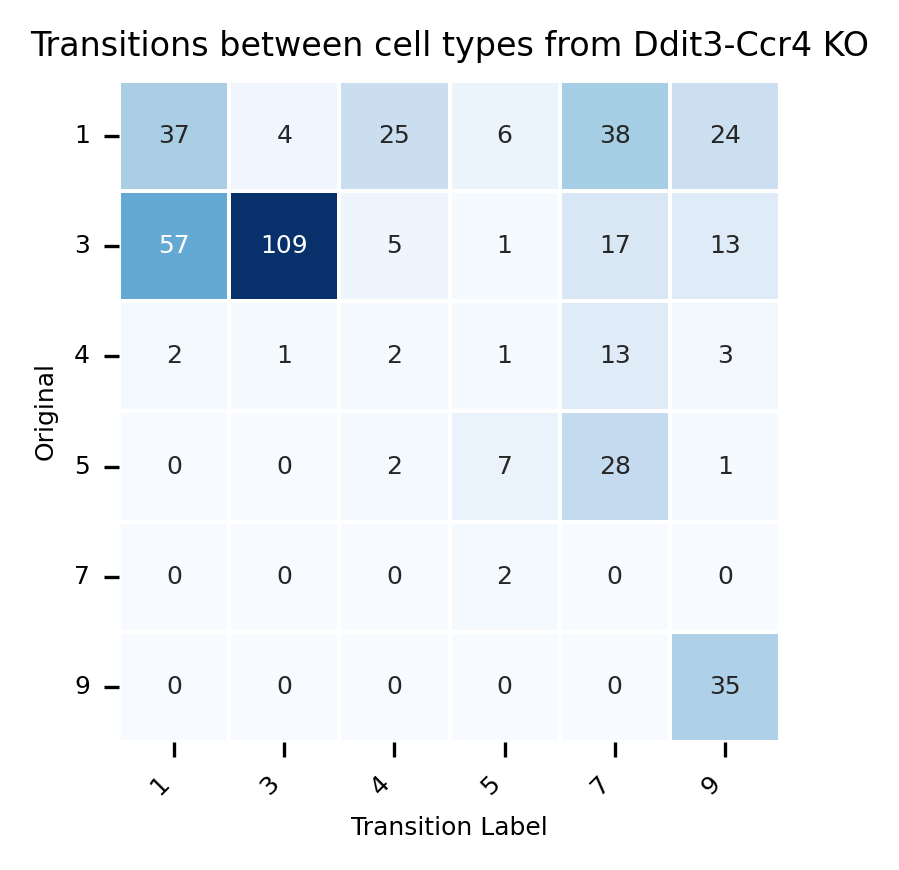

In [35]:
plt.figure(figsize=(3,3), dpi=300)

# Ensure counts has same number of rows and columns
if counts.empty:
    # Create empty DataFrame with same index and columns
    counts = pd.DataFrame(0, index=counts.index, columns=counts.columns)
elif len(counts.index) != len(counts.columns):
    # Add missing rows/columns with zeros
    all_labels = sorted(set(counts.index) | set(counts.columns))
    counts = counts.reindex(index=all_labels, columns=all_labels, fill_value=0)

sns.heatmap(
    counts,
    annot=True,
    fmt='d',  # Changed to integer format
    cmap='Blues',
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    square=True,
    annot_kws={"size": 6}
)

plt.title(f"Transitions between cell types from {goi} KO", fontsize=8)
plt.xlabel("Transition Label", fontsize=6)
plt.ylabel("Original", fontsize=6)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)

plt.tight_layout()
plt.savefig(f'mouse_lymph1_{goi}_transitions_Th2.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

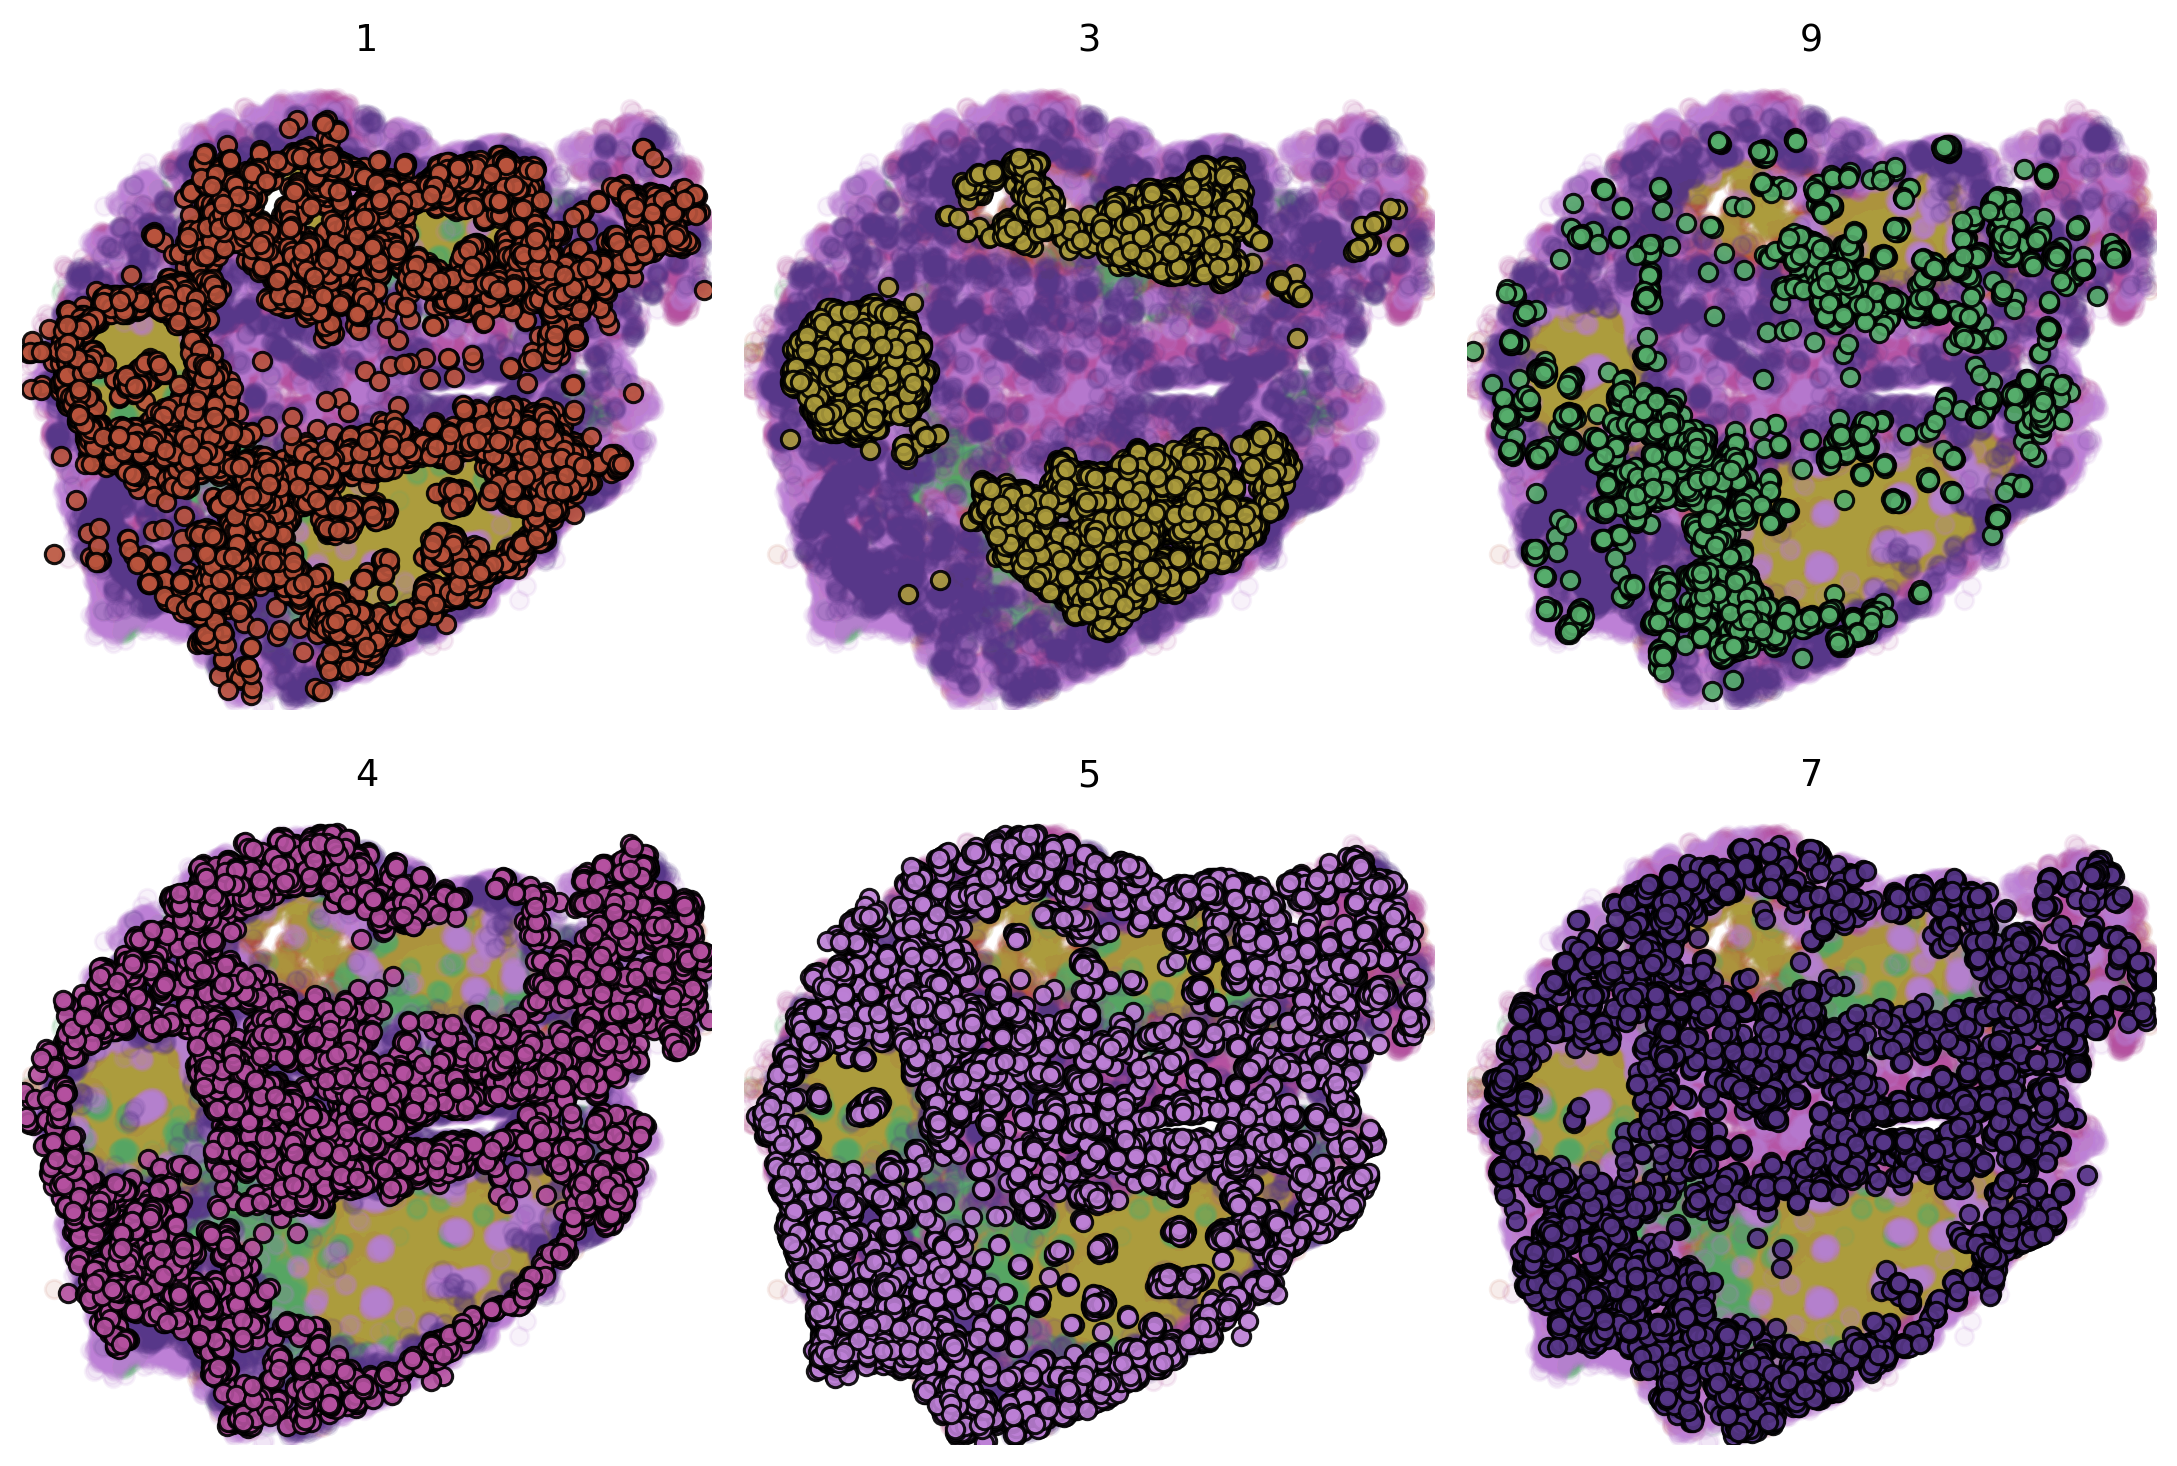

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7), dpi=220)
axs = axs.flatten()

for i, bcluster in enumerate(chart.adata.obs['banksy_cluster'].unique()):

    for j, background in enumerate(chart.adata.obs['banksy_cluster'].unique()):
        axs[i].scatter(
            adata[adata.obs['banksy_cluster'] == background].obsm['spatial'][:, 0],
            adata[adata.obs['banksy_cluster'] == background].obsm['spatial'][:, 1],
            c=color_dict[background], alpha=0.1,
        )
    axs[i].scatter(
        adata[adata.obs['banksy_cluster'] == bcluster].obsm['spatial'][:, 0],
        adata[adata.obs['banksy_cluster'] == bcluster].obsm['spatial'][:, 1],
        c=color_dict[bcluster], alpha=0.9, edgecolor='black', linewidth=1,
        label=bcluster
    )

    axs[i].set_title(bcluster)
    axs[i].axis('off')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
    axs[i].set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)

plt.tight_layout()
plt.show()


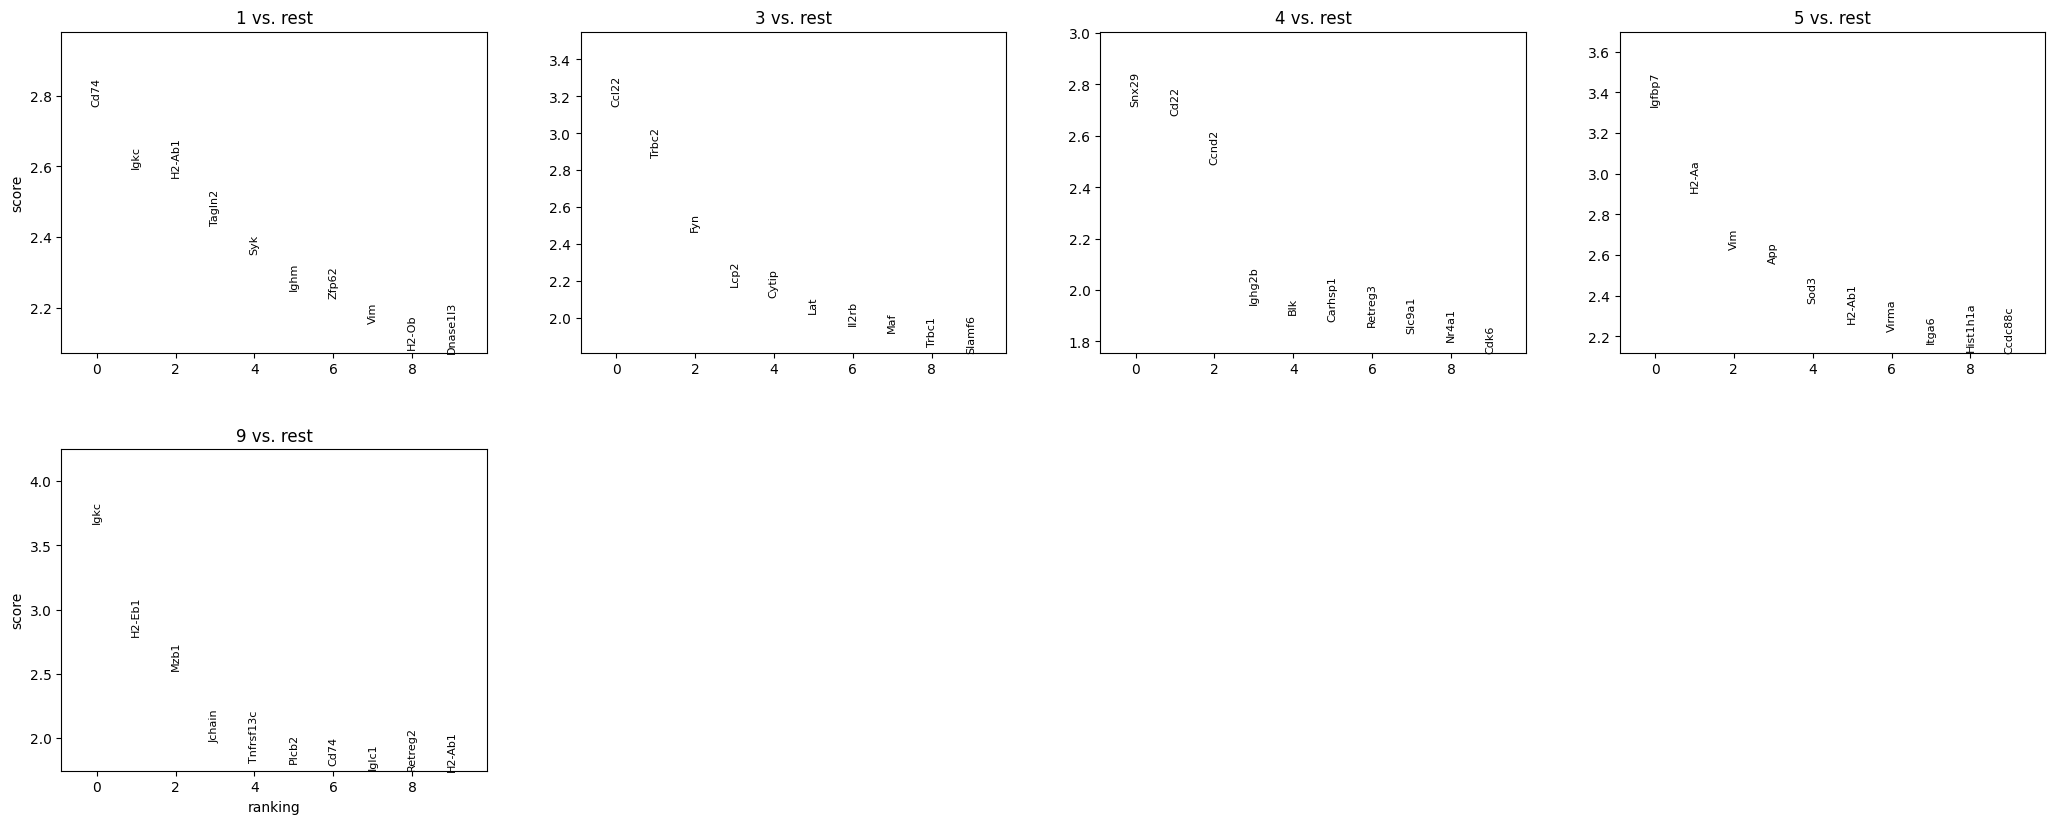

In [205]:
sc.tl.rank_genes_groups(adata_, groupby='banksy_cluster', method='wilcoxon', layer='normalized_count')
sc.pl.rank_genes_groups(adata_, n_genes=10, sharey=False)

In [206]:
# Get the ranked genes for each cluster
ranked_genes = sc.get.rank_genes_groups_df(adata_, group=None, key='rank_genes_groups')

for cluster in adata_.obs.banksy_cluster.unique():
    tmp = ranked_genes[ranked_genes['group'] == str(cluster)]
    tmp = tmp[tmp['pvals'] < 0.05]
    print(cluster, tmp.sort_values(by='logfoldchanges', ascending=False)['names'].values)

3 ['Ccl22' 'Lcp2' 'Fyn' 'Trbc2' 'Cytip' 'Lat' 'Ighd' 'Ighm' 'H2-Aa' 'Cd74'
 'Cd79b' 'H2-Eb1' 'H2-Ob' 'H2-Ab1' 'Hist1h1b' 'Aldh18a1' 'Igkc' 'Mzb1']
9 ['Jchain' 'Mzb1' 'Igkc' 'H2-Eb1' 'Trbc2' 'Fyn' 'Sh2d2a' 'Maf' 'Trac']
5 ['Igfbp7' 'Sod3' 'Virma' 'Fcer2a' 'Ccdc88c' 'Itga6' 'Hist1h1a' 'App'
 'H2-Aa' 'H2-Ab1' 'Vim' 'Tpt1']
4 ['Snx29' 'Cd22' 'Ccnd2']
1 ['Zfp62' 'Dnase1l3' 'Cfb' 'Ddrgk1' 'Syk' 'Cd3e' 'Igkc' 'H2-Ab1' 'Tagln2'
 'Cd74' 'H2-Ob' 'H2-Aa' 'Trac' 'Vim' 'Ighm' 'Prdm1' 'Ccl22']


In [207]:
tmp = ranked_genes[ranked_genes['group'] == str(3)]
tmp = tmp[tmp['pvals'] < 0.05]
tmp

group     names    scores  logfoldchanges         pvals  pvals_adj
2116     3     Ccl22  3.149238        3.951319  1.636971e-03   0.740717
2117     3     Trbc2  2.870787        2.004879  4.094514e-03   1.000000
2118     3       Fyn  2.470759        2.017811  1.348266e-02   1.000000
2119     3      Lcp2  2.168777        2.669532  3.009958e-02   1.000000
2120     3     Cytip  2.109950        1.983877  3.486267e-02   1.000000
2121     3       Lat  2.023669        1.793357  4.300417e-02   1.000000
4220     3  Aldh18a1 -1.984451       -2.176006  4.720558e-02   1.000000
4221     3  Hist1h1b -1.996217       -2.085473  4.591035e-02   1.000000
4222     3      Ighd -2.066810       -1.080525  3.875209e-02   1.000000
4223     3     Cd79b -2.094263       -1.349852  3.623660e-02   1.000000
4224     3      Mzb1 -2.188387       -4.653568  2.864144e-02   1.000000
4225     3     H2-Ob -2.682539       -1.806747  7.306572e-03   1.000000
4226     3     H2-Aa -2.843334       -1.170821  4.464425e-03   1.000000
4227     3      Ighm -2.894318       -1.106339  3.799832e-03   1.000000
4228     3    H2-Eb1 -3.129628       -1.494447  1.750276e-03   0.740717
4229     3      Cd74 -3.835560       -1.300040  1.252787e-04   0.088363
4230     3    H2-Ab1 -4.321868       -1.871164  1.547139e-05   0.016369
4231     3      Igkc -5.357234       -2.910552  8.450588e-08   0.000179

### Radar plots

In [336]:
import random
from spaceoracle.virtual_tissue import SubsampledTissue

lymph = SubsampledTissue(
    adata = adata,
    annot = 'cell_type',
    betadatas_paths = None,
    ko_paths = [
        '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1a_visiumHD',
        '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1b_visiumHD',
        '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1c_visiumHD',
        '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1d_visiumHD',
    ],
    suffix = '',
    n_props=4
)

In [6]:
# ko_file = '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1a_visiumHD/Pax5_4n_0x.parquet'
            
# data = pd.read_parquet(ko_file)
# data = data.loc[adata.obs.index]

# data = data.loc[adata.obs_names] - adata.to_df(layer='imputed_count')
# data

In [7]:
# plt.hist(data.loc[adata.obs.cell_type == 'Resting T']['Zmynd15'].values, label='Resting T', bins=100)
# plt.hist(data.loc[adata.obs.cell_type == 'B']['Zmynd15'], bins=100, alpha=0.5, label='B')
# plt.semilogy()
# plt.legend()

In [337]:
genes=[
        ['Gata3', 'Pax5', 'Bcl6', 'Prdm1', 'Foxp3', 'Stat4'], 
        ['Il2ra', 'Ccr4', 'Il6st', 'Cxcr4', 'Il4ra', 'Cxcr5'],
        ['Il2', 'Il4', 'Ccl5', 'Il15', 'Cxcl13', 'Lgals9']
]

In [338]:
lymph.compute_ko_impact(genes=genes, cache_path='', force_recompute=True)

Gata3      Pax5      Bcl6     Prdm1     Foxp3     Stat4  \
Th2        0.000027  0.000071  0.000013  0.000027  0.000038  0.000043   
Tfh        0.000026  0.000052  0.000028  0.000011  0.000020  0.000074   
Treg       0.000019  0.000051  0.000019  0.000010  0.000067  0.000082   
Resting T  0.000014  0.000086  0.000018  0.000005  0.000012  0.000061   
DC         0.000013  0.000071  0.000016  0.000011  0.000014  0.000067   
gd T       0.000009  0.000059  0.000017  0.000007  0.000007  0.000057   
CD8+ T     0.000008  0.000072  0.000017  0.000006  0.000012  0.000084   
NK         0.000006  0.000077  0.000022  0.000006  0.000006  0.000084   
B          0.000005  0.000203  0.000031  0.000004  0.000005  0.000051   

              Il2ra          Ccr4     Il6st     Cxcr4     Il4ra     Cxcr5  \
Th2        0.000063  2.886854e-05  0.000074  0.000031  0.000043  0.000036   
Tfh        0.000035  4.249275e-05  0.000102  0.000020  0.000047  0.000049   
Treg       0.000041  2.691835e-05  0.000118  0.000017  0.000060  0.000024   
Resting T  0.000016  9.979176e-06  0.000099  0.000019  0.000074  0.000033   
DC         0.000023  1.042133e-05  0.000138  0.000025  0.000068  0.000029   
gd T       0.000012  4.789122e-06  0.000210  0.000025  0.000049  0.000031   
CD8+ T     0.000021  1.212513e-05  0.000100  0.000021  0.000065  0.000028   
NK         0.000010  6.753499e-07  0.000150  0.000011  0.000045  0.000032   
B          0.000006  4.227533e-06  0.000052  0.000031  0.000080  0.000073   

                    Il2       Il4      Ccl5      Il15    Cxcl13    Lgals9  
Th2        6.193720e-10  0.000003  0.000061  0.000004  0.000019  0.000028  
Tfh        5.135294e-06  0.000010  0.000066  0.000003  0.000022  0.000025  
Treg       8.021483e-07  0.000005  0.000094  0.000003  0.000007  0.000034  
Resting T  1.223771e-06  0.000003  0.000078  0.000004  0.000009  0.000033  
DC         9.666779e-07  0.000002  0.000121  0.000013  0.000037  0.000029  
gd T       4.985546e-10  0.000003  0.000056  0.000022  0.000014  0.000026  
CD8+ T     5.276888e-07  0.000004  0.000121  0.000006  0.000008  0.000032  
NK         7.724278e-10  0.000001  0.000165  0.000016  0.000025  0.000039  
B          3.108475e-07  0.000004  0.000021  0.000002  0.000066  0.000035

In [339]:
adata.obs['cell_type'].unique()

['B', 'CD8+ T', 'Resting T', 'DC', 'Th2', 'gd T', 'Tfh', 'Treg', 'NK']
Categories (9, object): ['B', 'CD8+ T', 'DC', 'NK', ..., 'Tfh', 'Th2', 'Treg', 'gd T']

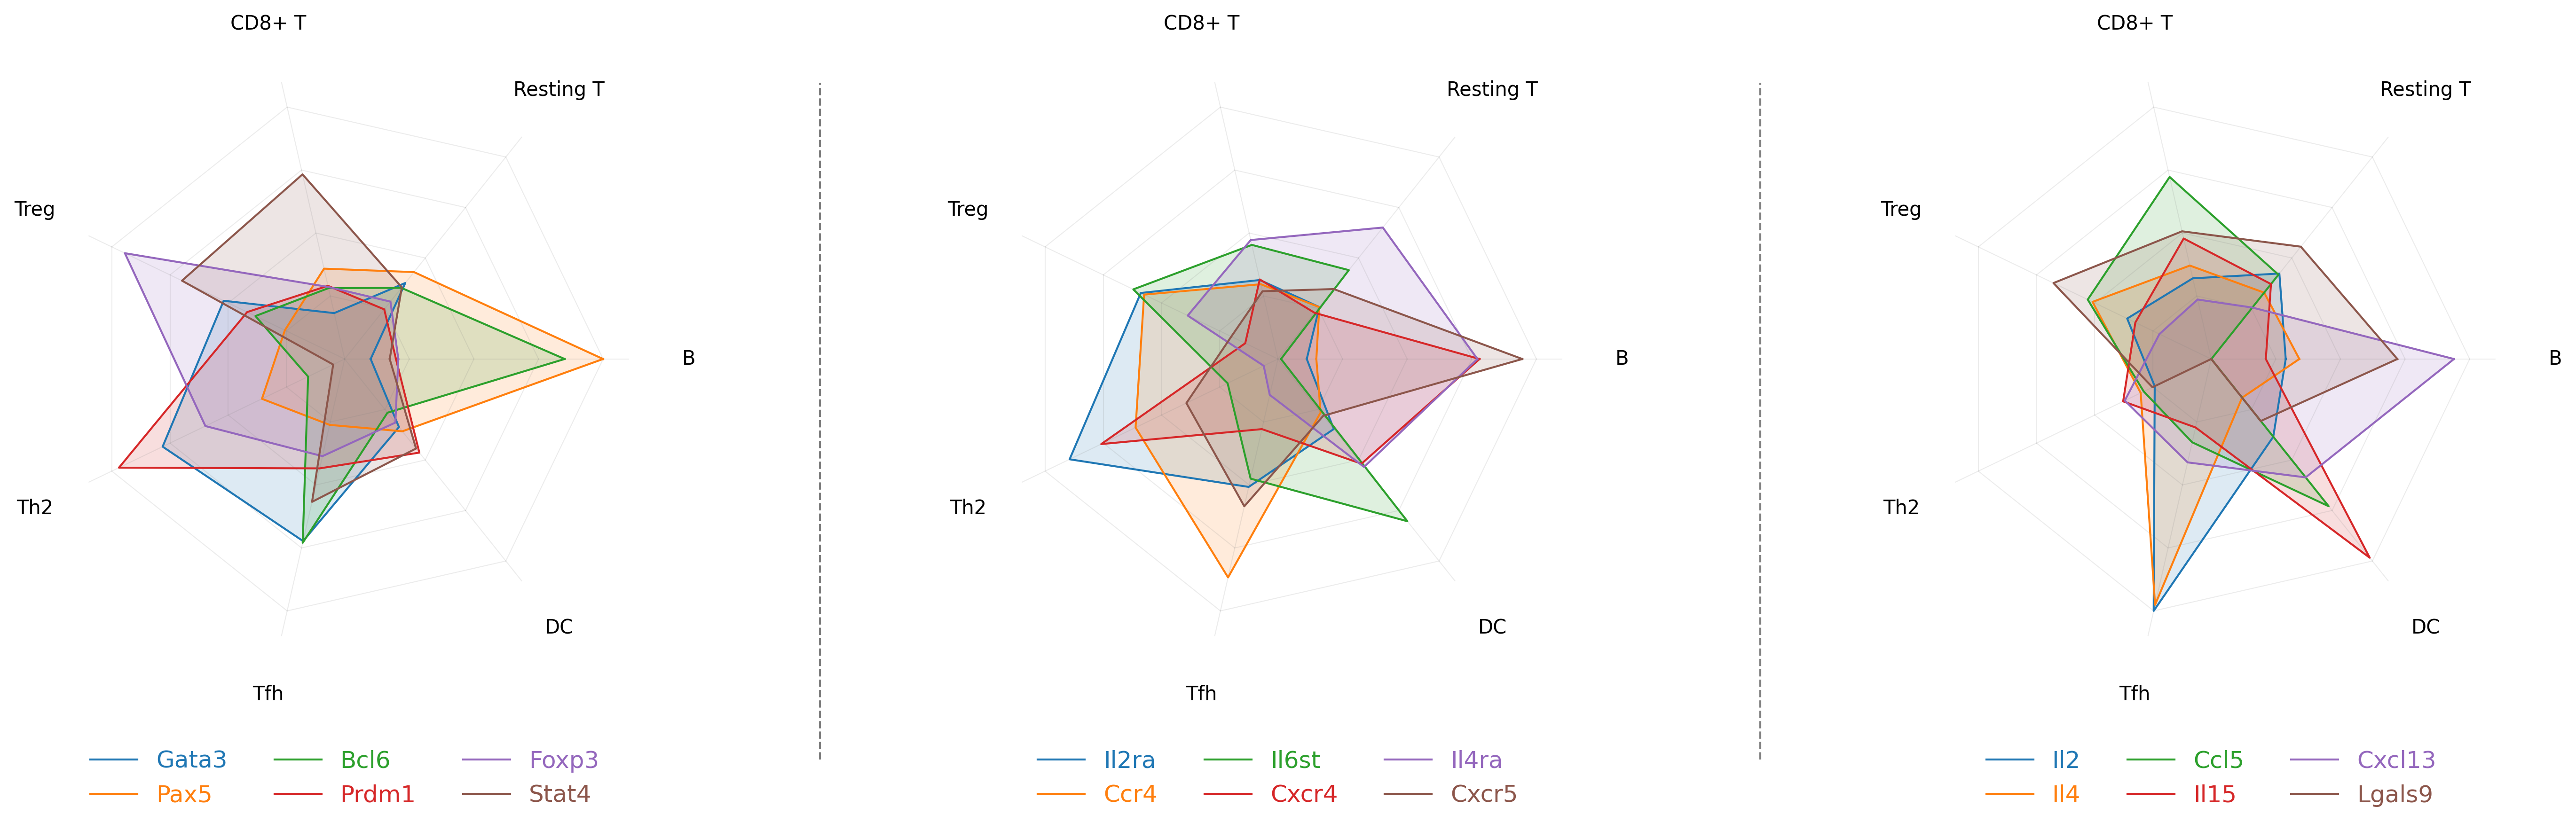

In [340]:
lymph.plot_radar(genes=genes, 
    show_for=['B', 'Resting T', 'CD8+ T', 'Treg', 'Th2', 'Tfh', 'DC'])

plt.savefig('lymph_radar.svg', dpi=300, bbox_inches='tight', transparent=True, format='svg')

In [18]:
ko_impact_df = pd.read_csv('ko_impact_df.csv', index_col=0)
ko_impact_df

Gata3      Pax5      Bcl6     Prdm1     Foxp3     Il2ra  \
Th2        0.002401  0.006597  0.000751  0.004720  0.002613  0.000063   
Tfh        0.001932  0.007758  0.001363  0.004458  0.001767  0.000035   
DC         0.001569  0.009989  0.001438  0.005709  0.000997  0.000023   
gd T       0.001138  0.007003  0.002027  0.001805  0.000505  0.000012   
Resting T  0.000956  0.006130  0.000303  0.000604  0.000487  0.000017   
Treg       0.000837  0.005245  0.000935  0.002303  0.001561  0.000040   
NK         0.000674  0.009562  0.003130  0.001549  0.000587  0.000010   
B          0.000476  0.004920  0.001274  0.001056  0.000318  0.000006   
CD8+ T     0.000294  0.006129  0.000440  0.000842  0.000383  0.000021   

                   Ccr4     Il6st     Cxcr4     Il4ra     Cxcr5           Il2  \
Th2        2.817911e-05  0.000074  0.000031  0.000043  0.000036  1.183489e-10   
Tfh        4.193997e-05  0.000101  0.000020  0.000047  0.000049  5.148095e-06   
DC         1.038362e-05  0.000139  0.000025  0.000068  0.000029  9.152119e-07   
gd T       4.936116e-06  0.000204  0.000026  0.000048  0.000031  1.093451e-10   
Resting T  1.001066e-05  0.000099  0.000019  0.000074  0.000033  1.229996e-06   
Treg       2.647980e-05  0.000118  0.000017  0.000060  0.000024  8.848785e-07   
NK         6.745812e-07  0.000149  0.000011  0.000046  0.000031  1.907944e-10   
B          4.243683e-06  0.000052  0.000031  0.000080  0.000072  3.078582e-07   
CD8+ T     1.208590e-05  0.000100  0.000021  0.000065  0.000028  5.485328e-07   

                Il4      Ccl5      Il15    Cxcl13    Lgals9  
Th2        0.000003  0.000061  0.000004  0.000019  0.000026  
Tfh        0.000010  0.000066  0.000002  0.000022  0.000023  
DC         0.000002  0.000121  0.000014  0.000038  0.000025  
gd T       0.000004  0.000059  0.000020  0.000014  0.000024  
Resting T  0.000003  0.000079  0.000004  0.000009  0.000027  
Treg       0.000005  0.000093  0.000003  0.000007  0.000028  
NK         0.000001  0.000164  0.000016  0.000025  0.000036  
B          0.000004  0.000021  0.000002  0.000065  0.000025  
CD8+ T     0.000004  0.000120  0.000006  0.000008  0.000028

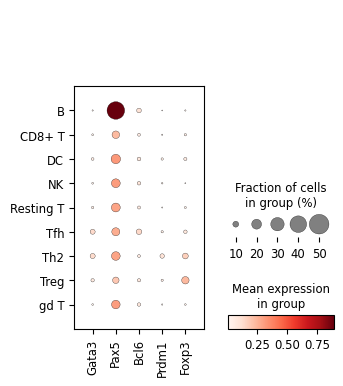

In [40]:
sc.pl.dotplot(adata, var_names=['Gata3', 'Pax5', 'Bcl6', 'Prdm1', 'Foxp3'], groupby='cell_type')

In [21]:
adata.to_df(layer='imputed_count').join(adata.obs.cell_type).groupby('cell_type').mean()['Pax5']

cell_type
B            0.429884
CD8+ T       0.151854
DC           0.151608
NK           0.160810
Resting T    0.181478
Tfh          0.109284
Th2          0.149069
Treg         0.109395
gd T         0.121704
Name: Pax5, dtype: float64